# 🔋 Notebook-4: Simple RUL Prediction with XGBoost

**Objective**: Train one working XGBoost model with normalized target.

**No LSTM. No SHAP. No complexity.**

---

## Setup

In [50]:
!pip install xgboost -q

In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler # Added this line
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Setup complete")

✅ Setup complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## 1️⃣ Load & Inspect

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
DATA_DIR = Path('/content/drive/MyDrive/4 month project/DataSet')
INPUT_FILE = DATA_DIR / 'labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl'

df = pd.read_pickle(INPUT_FILE)

print("📊 Dataset Shape:", df.shape)
print("\n🔍 NaN Counts:")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("\n🔋 Cycles per Battery:")
cycles_per_battery = df.groupby('battery_id')['cycle_no'].count().sort_values(ascending=False)
print(cycles_per_battery)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Dataset Shape: (2142, 17)

🔍 NaN Counts:
cap_delta             34
cap_delta_roll       102
chg_voltage_mean    2142
chg_current_mean    2142
chg_temp_mean       2142
dtype: int64

🔋 Cycles per Battery:
battery_id
B0036    197
B0033    197
B0034    197
B0005    168
B0006    168
B0007    168
B0054     77
B0055     77
B0056     77
B0018     68
B0053     56
B0038     47
B0040     47
B0039     47
B0043     42
B0044     42
B0042     42
B0030     40
B0032     40
B0031     40
B0029     40
B0027     28
B0026     28
B0025     28
B0028     28
B0045     20
B0046     20
B0048     20
B0047     20
B0052     17
B0050     17
B0051     17
B0049     17
B0041      5
Name: cycle_no, dtype: int64


---

## 2️⃣ Battery-wise Split

In [ ]:
# Get battery list sorted by cycle count
batteries = df.groupby('battery_id')['cycle_no'].count().sort_values(ascending=False).index.tolist()

# Alternate assignment
train_batteries = []
val_batteries = []
test_batteries = []

for i, battery in enumerate(batteries):
    if i % 5 < 3:  # 60%
        train_batteries.append(battery)
    elif i % 5 == 3:  # 20%
        val_batteries.append(battery)
    else:  # 20%
        test_batteries.append(battery)

# Split dataframes
df_train = df[df['battery_id'].isin(train_batteries)].copy()
df_val = df[df['battery_id'].isin(val_batteries)].copy()
df_test = df[df['battery_id'].isin(test_batteries)].copy()

print("✅ Split Complete:")
print(f"  TRAIN: {len(train_batteries)} batteries, {len(df_train):,} rows")
print(f"  VAL:   {len(val_batteries)} batteries, {len(df_val):,} rows")
print(f"  TEST:  {len(test_batteries)} batteries, {len(df_test):,} rows")

# Assert minimum size
assert len(df_train) > 300, f"❌ TRAIN too small: {len(df_train)}"
assert len(df_val) > 300, f"❌ VAL too small: {len(df_val)}"
assert len(df_test) > 300, f"❌ TEST too small: {len(df_test)}"
print("\n✅ All splits > 300 rows")

✅ Split Complete:
  TRAIN: 21 batteries, 1,394 rows
  VAL:   7 batteries, 385 rows
  TEST:  6 batteries, 363 rows

✅ All splits > 300 rows


---

## 3️⃣ Target Construction: RUL_frac

In [ ]:
def compute_rul_frac(df):
    """Compute RUL_frac = RUL / EOL_cycle"""
    eol_cycles = df.groupby('battery_id')['cycle_no'].max().to_dict()
    df['EOL_cycle'] = df['battery_id'].map(eol_cycles)
    df['RUL_frac'] = df['RUL'] / df['EOL_cycle']
    return df

df_train = compute_rul_frac(df_train)
df_val = compute_rul_frac(df_val)
df_test = compute_rul_frac(df_test)

# Validate
for name, df_split in [('TRAIN', df_train), ('VAL', df_val), ('TEST', df_test)]:
    assert df_split['RUL_frac'].isnull().sum() == 0, f"❌ {name} has NaN in RUL_frac"
    assert (df_split['RUL_frac'] >= 0).all(), f"❌ {name} has RUL_frac < 0"
    assert (df_split['RUL_frac'] <= 1).all(), f"❌ {name} has RUL_frac > 1"

print("✅ RUL_frac computed successfully")
print(f"  TRAIN range: [{df_train['RUL_frac'].min():.4f}, {df_train['RUL_frac'].max():.4f}]")
print(f"  VAL range:   [{df_val['RUL_frac'].min():.4f}, {df_val['RUL_frac'].max():.4f}]")
print(f"  TEST range:  [{df_test['RUL_frac'].min():.4f}, {df_test['RUL_frac'].max():.4f}]")

✅ RUL_frac computed successfully
  TRAIN range: [0.0000, 0.9979]
  VAL range:   [0.0000, 0.9967]
  TEST range:  [0.0000, 0.9967]


---

## 4️⃣ Feature Engineering

In [ ]:
def add_lag_features(df):
    """Add lag features per battery"""
    df = df.sort_values(['battery_id', 'cycle_no']).copy()

    # Find capacity and SOH columns
    capacity_col = None
    for col in df.columns:
        if 'capacity' in col.lower() and 'discharge' in col.lower():
            capacity_col = col
            break

    # Create lag features
    if capacity_col:
        df[f'delta_{capacity_col}'] = df.groupby('battery_id')[capacity_col].diff()
        print(f"  ✓ Created delta_{capacity_col}")

    if 'SOH' in df.columns:
        df['delta_SOH'] = df.groupby('battery_id')['SOH'].diff()
        print(f"  ✓ Created delta_SOH")

    return df

print("🔧 Creating lag features...")
df_train = add_lag_features(df_train)
df_val = add_lag_features(df_val)
df_test = add_lag_features(df_test)

print("\n✅ Lag features created")

🔧 Creating lag features...
  ✓ Created delta_SOH
  ✓ Created delta_SOH
  ✓ Created delta_SOH

✅ Lag features created


In [ ]:
# Drop cycle_no and related features, and columns with all NaNs
exclude_cols = [
    'battery_id', 'cycle_no', 'RUL', 'RUL_frac', 'EOL_cycle',
    'chg_voltage_mean', 'chg_current_mean', 'chg_temp_mean' # Exclude these columns, as they are all NaNs
]
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"📋 Selected {len(feature_cols)} features")
print(f"   First 10: {feature_cols[:10]}")

# Prepare matrices
X_train = df_train[feature_cols].copy()
y_train = df_train['RUL_frac'].copy()

X_val = df_val[feature_cols].copy()
y_val = df_val['RUL_frac'].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test['RUL_frac'].copy()

print(f"\n📊 Shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

📋 Selected 12 features
   First 10: ['voltage_mean', 'voltage_min', 'voltage_max', 'temp_mean', 'discharge_time_sec', 'capacity_Ah', 'cap_delta', 'cap_delta_roll', 'has_charge', 'has_impedance']

📊 Shapes:
  X_train: (1394, 12)
  X_val:   (385, 12)
  X_test:  (363, 12)


In [ ]:
# Drop first cycle per battery (has NaN in lag features)
def drop_first_cycle(df, X, y):
    """Drop first cycle of each battery"""
    first_cycles = df.groupby('battery_id')['cycle_no'].min()
    mask = ~((df['battery_id'].isin(first_cycles.index)) &
             (df['cycle_no'].isin(first_cycles.values)))

    indices_to_keep = df[mask].index
    df_clean = df.loc[indices_to_keep] # Also clean the df
    X_clean = X.loc[indices_to_keep]
    y_clean = y.loc[indices_to_keep]

    return df_clean, X_clean, y_clean

print("🔧 Dropping first cycle per battery...")
df_train, X_train, y_train = drop_first_cycle(df_train, X_train, y_train)
df_val, X_val, y_val = drop_first_cycle(df_val, X_val, y_val)
df_test, X_test, y_test = drop_first_cycle(df_test, X_test, y_test)

print(f"\n✅ After dropping first cycles:")
print(f"  df_train: {df_train.shape}")
print(f"  X_train: {X_train.shape}")
print(f"  df_val:   {df_val.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  df_test:  {df_test.shape}")
print(f"  X_test:  {X_test.shape}")

🔧 Dropping first cycle per battery...

✅ After dropping first cycles:
  df_train: (1370, 20)
  X_train: (1370, 12)
  df_val:   (375, 20)
  X_val:   (375, 12)
  df_test:  (355, 20)
  X_test:  (355, 12)


In [ ]:
# Before imputation, ensure all feature columns are numeric
# This explicitly converts potential 'object' or 'boolean' columns to float,
# making them amenable to SimpleImputer and handling potential non-numeric entries.
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Fill remaining NaNs with median
print(f"\n🔍 NaNs before imputation:")
print(f"  X_train: {X_train.isnull().sum().sum()}")
print(f"  X_val:   {X_val.isnull().sum().sum()}")
print(f"  X_test:  {X_test.isnull().sum().sum()}")

if X_train.isnull().sum().sum() > 0:
    print("\n🔧 Imputing with median...")
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train),
                           columns=X_train.columns, index=X_train.index)
    X_val = pd.DataFrame(imputer.transform(X_val),
                         columns=X_val.columns, index=X_val.index)
    X_test = pd.DataFrame(imputer.transform(X_test),
                          columns=X_test.columns, index=X_test.index)

    print(f"\n✅ After imputation:")
    print(f"  X_train NaNs: {X_train.isnull().sum().sum()}")
    print(f"  X_val NaNs:   {X_val.isnull().sum().sum()}")
    print(f"  X_test NaNs:  {X_test.isnull().sum().sum()}")

# Validate targets
assert y_train.isnull().sum() == 0, "❌ y_train has NaNs"
assert y_val.isnull().sum() == 0, "❌ y_val has NaNs"
assert y_test.isnull().sum() == 0, "❌ y_test has NaNs"
print("\n✅ No NaNs in targets")


🔍 NaNs before imputation:
  X_train: 39
  X_val:   11
  X_test:  10

🔧 Imputing with median...

✅ After imputation:
  X_train NaNs: 0
  X_val NaNs:   0
  X_test NaNs:  0

✅ No NaNs in targets


---

## 5️⃣ Train XGBoost

In [ ]:
print("🚀 Training XGBoost...\n")

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbosity=0
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print("✅ Training complete")

🚀 Training XGBoost...

✅ Training complete


---

## 6️⃣ Evaluate

In [ ]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Compute metrics
def compute_metrics(y_true, y_pred, split_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{split_name}:")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.6f}")

    return mae, rmse, r2

print("="*50)
print("📊 FINAL METRICS (RUL_frac)")
print("="*50)

mae_train, rmse_train, r2_train = compute_metrics(y_train, y_pred_train, 'TRAIN')
mae_val, rmse_val, r2_val = compute_metrics(y_val, y_pred_val, 'VAL')
mae_test, rmse_test, r2_test = compute_metrics(y_test, y_pred_test, 'TEST')

print("\n" + "="*50)

📊 FINAL METRICS (RUL_frac)

TRAIN:
  MAE:  0.055615
  RMSE: 0.074554
  R²:   0.932494

VAL:
  MAE:  0.151032
  RMSE: 0.212240
  R²:   0.465550

TEST:
  MAE:  0.194986
  RMSE: 0.241670
  R²:   0.298050



---

## 📋 Summary Output

In [ ]:
print("\n" + "="*50)
print("📋 SUMMARY FOR COPY-PASTE")
print("="*50)
print(f"""
TRAIN rows: {len(X_train)}
VAL rows: {len(X_val)}
TEST rows: {len(X_test)}

NaNs in X_train: {X_train.isnull().sum().sum()}
NaNs in y_train: {y_train.isnull().sum()}

TRAIN MAE: {mae_train:.6f}
VAL MAE: {mae_val:.6f}
TEST MAE: {mae_test:.6f}
""")
print("="*50)


📋 SUMMARY FOR COPY-PASTE

TRAIN rows: 1370
VAL rows: 375
TEST rows: 355

NaNs in X_train: 0
NaNs in y_train: 0

TRAIN MAE: 0.055615
VAL MAE: 0.151032
TEST MAE: 0.194986



LightGBM

In [ ]:
!pip install lightgbm -q

In [ ]:
import lightgbm as lgb

print("✅ LightGBM imported")

✅ LightGBM imported


In [ ]:
print("🚀 Training LightGBM...\n")

# Conservative LightGBM settings
model_lgb = lgb.LGBMRegressor(
    num_leaves=31,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbosity=-1
)

# Train with early stopping
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

print(f"✅ Training complete (best iteration: {model_lgb.best_iteration_})")

🚀 Training LightGBM...

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	training's l2: 0.0029907	valid_1's l2: 0.0485729
✅ Training complete (best iteration: 100)


In [ ]:
# Predictions
y_pred_train_lgb = model_lgb.predict(X_train)
y_pred_val_lgb = model_lgb.predict(X_val)
y_pred_test_lgb = model_lgb.predict(X_test)

# Compute metrics using existing function
print("="*50)
print("📊 LIGHTGBM METRICS (RUL_frac)")
print("="*50)

mae_train_lgb, rmse_train_lgb, r2_train_lgb = compute_metrics(y_train, y_pred_train_lgb, 'TRAIN')
mae_val_lgb, rmse_val_lgb, r2_val_lgb = compute_metrics(y_val, y_pred_val_lgb, 'VAL')
mae_test_lgb, rmse_test_lgb, r2_test_lgb = compute_metrics(y_test, y_pred_test_lgb, 'TEST')

print("\n" + "="*50)

📊 LIGHTGBM METRICS (RUL_frac)

TRAIN:
  MAE:  0.037612
  RMSE: 0.054687
  R²:   0.963678

VAL:
  MAE:  0.141205
  RMSE: 0.220393
  R²:   0.423704

TEST:
  MAE:  0.191597
  RMSE: 0.255001
  R²:   0.218475



In [ ]:
# Compute 95th percentile absolute error for both models
def compute_p95(y_true, y_pred):
    """Compute 95th percentile absolute error"""
    abs_errors = np.abs(y_true - y_pred)
    return np.percentile(abs_errors, 95)

# XGBoost P95
p95_train_xgb = compute_p95(y_train, y_pred_train)
p95_val_xgb = compute_p95(y_val, y_pred_val)
p95_test_xgb = compute_p95(y_test, y_pred_test)

# LightGBM P95
p95_train_lgb = compute_p95(y_train, y_pred_train_lgb)
p95_val_lgb = compute_p95(y_val, y_pred_val_lgb)
p95_test_lgb = compute_p95(y_test, y_pred_test_lgb)

print("✅ 95th percentile errors computed")

✅ 95th percentile errors computed


comparison

In [ ]:
# Create comparison dataframe
comparison_data = {
    'Split': ['TRAIN', 'TRAIN', 'VAL', 'VAL', 'TEST', 'TEST'],
    'Model': ['XGBoost', 'LightGBM', 'XGBoost', 'LightGBM', 'XGBoost', 'LightGBM'],
    'MAE': [mae_train, mae_train_lgb, mae_val, mae_val_lgb, mae_test, mae_test_lgb],
    'RMSE': [rmse_train, rmse_train_lgb, rmse_val, rmse_val_lgb, rmse_test, rmse_test_lgb],
    'R²': [r2_train, r2_train_lgb, r2_val, r2_val_lgb, r2_test, r2_test_lgb],
    'P95': [p95_train_xgb, p95_train_lgb, p95_val_xgb, p95_val_lgb, p95_test_xgb, p95_test_lgb]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📊 MODEL COMPARISON: XGBoost vs LightGBM")
print("="*80)
print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


📊 MODEL COMPARISON: XGBoost vs LightGBM


Split    Model      MAE     RMSE       R²      P95
TRAIN  XGBoost 0.055615 0.074554 0.932494 0.149733
TRAIN LightGBM 0.037612 0.054687 0.963678 0.116691
  VAL  XGBoost 0.151032 0.212240 0.465550 0.491247
  VAL LightGBM 0.141205 0.220393 0.423704 0.589533
 TEST  XGBoost 0.194986 0.241670 0.298050 0.470112
 TEST LightGBM 0.191597 0.255001 0.218475 0.549799



In [ ]:
# Focus on validation performance
print("\n" + "="*80)
print("🎯 VALIDATION SET PERFORMANCE (Key Decision Metric)")
print("="*80)

val_comparison = comparison_df[comparison_df['Split'] == 'VAL'].copy()
print("\n")
print(val_comparison.to_string(index=False))

# Compute differences
mae_diff = mae_val_lgb - mae_val
rmse_diff = rmse_val_lgb - rmse_val
r2_diff = r2_val_lgb - r2_val

print("\n📈 Differences (LightGBM - XGBoost):")
print(f"  ΔMAE:  {mae_diff:+.6f}  {'✅ LightGBM better' if mae_diff < 0 else '❌ XGBoost better'}")
print(f"  ΔRMSE: {rmse_diff:+.6f}  {'✅ LightGBM better' if rmse_diff < 0 else '❌ XGBoost better'}")
print(f"  ΔR²:   {r2_diff:+.6f}  {'✅ LightGBM better' if r2_diff > 0 else '❌ XGBoost better'}")

# Determine winner
if mae_val_lgb < mae_val:
    winner = "LightGBM"
    improvement = (mae_val - mae_val_lgb) / mae_val * 100
else:
    winner = "XGBoost"
    improvement = (mae_val_lgb - mae_val) / mae_val_lgb * 100

print(f"\n🏆 WINNER: {winner} (MAE improvement: {improvement:.2f}%)")
print("="*80)


🎯 VALIDATION SET PERFORMANCE (Key Decision Metric)


Split    Model      MAE     RMSE       R²      P95
  VAL  XGBoost 0.151032 0.212240 0.465550 0.491247
  VAL LightGBM 0.141205 0.220393 0.423704 0.589533

📈 Differences (LightGBM - XGBoost):
  ΔMAE:  -0.009827  ✅ LightGBM better
  ΔRMSE: +0.008152  ❌ XGBoost better
  ΔR²:   -0.041846  ❌ XGBoost better

🏆 WINNER: LightGBM (MAE improvement: 6.51%)


In [ ]:
print("\n" + "="*80)
print("📋 FINAL SUMMARY - LIGHTGBM vs XGBOOST")
print("="*80)

summary = f"""
MODEL CONFIGURATION:
  XGBoost:   max_depth=3, n_estimators=200, lr=0.05
  LightGBM:  max_depth=6, n_estimators=300, lr=0.05

VALIDATION PERFORMANCE:
  XGBoost   MAE: {mae_val:.6f}  |  R²: {r2_val:.6f}
  LightGBM  MAE: {mae_val_lgb:.6f}  |  R²: {r2_val_lgb:.6f}

TEST PERFORMANCE:
  XGBoost   MAE: {mae_test:.6f}  |  R²: {r2_test:.6f}
  LightGBM  MAE: {mae_test_lgb:.6f}  |  R²: {r2_test_lgb:.6f}

CONCLUSION:
  Best Model: {winner}
  Validation Improvement: {improvement:.2f}%

RECOMMENDATION:
  {'Use LightGBM for deployment' if winner == 'LightGBM' else 'Use XGBoost for deployment'}
"""

print(summary)
print("="*80)


📋 FINAL SUMMARY - LIGHTGBM vs XGBOOST

MODEL CONFIGURATION:
  XGBoost:   max_depth=3, n_estimators=200, lr=0.05
  LightGBM:  max_depth=6, n_estimators=300, lr=0.05

VALIDATION PERFORMANCE:
  XGBoost   MAE: 0.151032  |  R²: 0.465550
  LightGBM  MAE: 0.141205  |  R²: 0.423704

TEST PERFORMANCE:
  XGBoost   MAE: 0.194986  |  R²: 0.298050
  LightGBM  MAE: 0.191597  |  R²: 0.218475

CONCLUSION:
  Best Model: LightGBM
  Validation Improvement: 6.51%

RECOMMENDATION:
  Use LightGBM for deployment



LSTM XGBOOST hybrid

In [ ]:
!pip install torch -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set PyTorch seed
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"✅ PyTorch imported")
print(f"   Device: {device}")
print(f"   PyTorch version: {torch.__version__}")

✅ PyTorch imported
   Device: cpu
   PyTorch version: 2.9.0+cpu


In [ ]:
print("\n" + "="*80)
print("🔬 GENERALIZATION-SAFE HYBRID MODEL")
print("="*80)
print("\nKey Design Choices:")
print("  • LSTM predicts ΔRUL_frac (degradation rate)")
print("  • Sequence balancing (max 50 per battery)")
print("  • Small LSTM (16 units → 8 embedding dims)")
print("  • Strong regularization throughout")
print("  • Identity leakage diagnostics")
print("="*80)


🔬 GENERALIZATION-SAFE HYBRID MODEL

Key Design Choices:
  • LSTM predicts ΔRUL_frac (degradation rate)
  • Sequence balancing (max 50 per battery)
  • Small LSTM (16 units → 8 embedding dims)
  • Strong regularization throughout
  • Identity leakage diagnostics


Compute ΔRUL_frac Target

In [ ]:
def compute_delta_rul_frac(df):
    """
    Compute ΔRUL_frac = RUL_frac(t) - RUL_frac(t-1) per battery.
    This represents the degradation rate.
    """
    print("\n🔧 Computing ΔRUL_frac (degradation rate)...")

    df = df.sort_values(['battery_id', 'cycle_no']).copy()

    # Compute delta within each battery
    df['delta_RUL_frac'] = df.groupby('battery_id')['RUL_frac'].diff()

    # First cycle has no delta (will be NaN)
    n_nan = df['delta_RUL_frac'].isnull().sum()

    # Validate
    df_valid = df[df['delta_RUL_frac'].notna()]

    assert np.isfinite(df_valid['delta_RUL_frac']).all(), "❌ Non-finite values in delta_RUL_frac"

    mean_delta = df_valid['delta_RUL_frac'].mean()
    std_delta = df_valid['delta_RUL_frac'].std()

    print(f"✅ ΔRUL_frac computed")
    print(f"   NaN count: {n_nan} (expected: one per battery)")
    print(f"   Mean: {mean_delta:.6f} (should be negative)")
    print(f"   Std:  {std_delta:.6f}")
    print(f"   Range: [{df_valid['delta_RUL_frac'].min():.6f}, {df_valid['delta_RUL_frac'].max():.6f}]")

    return df

# Apply to all splits
df_train = compute_delta_rul_frac(df_train)
df_val = compute_delta_rul_frac(df_val)
df_test = compute_delta_rul_frac(df_test)


🔧 Computing ΔRUL_frac (degradation rate)...
✅ ΔRUL_frac computed
   NaN count: 21 (expected: one per battery)
   Mean: -0.014639 (should be negative)
   Std:  0.015694
   Range: [-0.097561, -0.003257]

🔧 Computing ΔRUL_frac (degradation rate)...
✅ ΔRUL_frac computed
   NaN count: 7 (expected: one per battery)
   Mean: -0.016532 (should be negative)
   Std:  0.019445
   Range: [-0.200000, -0.003257]

🔧 Computing ΔRUL_frac (degradation rate)...
✅ ΔRUL_frac computed
   NaN count: 6 (expected: one per battery)
   Mean: -0.016153 (should be negative)
   Std:  0.014941
   Range: [-0.097561, -0.003257]


balanced sequence construction

In [ ]:
WINDOW_SIZE_DELTA = 10
MAX_SEQUENCES_PER_BATTERY = 50  # Prevent long-life battery dominance

def create_balanced_sequences(df, X, y, window_size=10, max_per_battery=50):
    """
    Create balanced sliding window sequences with limits per battery.
    Target is ΔRUL_frac at final timestep.
    """
    print(f"\n🔧 Creating balanced sequences (window={window_size}, max={max_per_battery})...")

    sequences = []
    targets = []  # Will store ΔRUL_frac
    valid_indices = []
    battery_counts = {}

    for battery_id in df['battery_id'].unique():
        battery_mask = df['battery_id'] == battery_id
        battery_data = df[battery_mask].sort_values('cycle_no')

        # Need at least window_size + 1 cycles (for delta at end)
        if len(battery_data) < window_size + 1:
            print(f"  ⚠️  Skipping {battery_id}: only {len(battery_data)} cycles")
            continue

        battery_X = X.loc[battery_data.index]
        battery_delta = df.loc[battery_data.index, 'delta_RUL_frac']

        # Collect all possible sequences
        temp_sequences = []
        temp_targets = []
        temp_indices = []

        for i in range(window_size, len(battery_data)):
            start_idx = i - window_size
            end_idx = i

            # Check if we have valid delta at end
            delta_target = battery_delta.iloc[end_idx]
            if pd.isna(delta_target):
                continue

            seq = battery_X.iloc[start_idx:end_idx].values
            idx = battery_data.index[end_idx]

            temp_sequences.append(seq)
            temp_targets.append(delta_target)
            temp_indices.append(idx)

        # Sample if too many
        n_sequences = len(temp_sequences)
        if n_sequences > max_per_battery:
            sample_indices = np.random.choice(n_sequences, max_per_battery, replace=False)
            sample_indices = sorted(sample_indices)  # Keep temporal order
            temp_sequences = [temp_sequences[i] for i in sample_indices]
            temp_targets = [temp_targets[i] for i in sample_indices]
            temp_indices = [temp_indices[i] for i in sample_indices]
            n_sequences = max_per_battery

        sequences.extend(temp_sequences)
        targets.extend(temp_targets)
        valid_indices.extend(temp_indices)
        battery_counts[battery_id] = n_sequences

    sequences = np.array(sequences)
    targets = np.array(targets)
    valid_indices = np.array(valid_indices)

    print(f"✅ Created {len(sequences):,} balanced sequences")
    print(f"   Shape: {sequences.shape}")
    print(f"   Batteries used: {len(battery_counts)}")
    print(f"   Sequences per battery: min={min(battery_counts.values())}, max={max(battery_counts.values())}, mean={np.mean(list(battery_counts.values())):.1f}")

    return sequences, targets, valid_indices

# Create balanced sequences
print("\n" + "="*60)
print("📦 BALANCED SEQUENCE CONSTRUCTION")
print("="*60)

X_seq_train_delta, y_delta_train, idx_delta_train = create_balanced_sequences(
    df_train, X_train, y_train, WINDOW_SIZE_DELTA, MAX_SEQUENCES_PER_BATTERY
)
X_seq_val_delta, y_delta_val, idx_delta_val = create_balanced_sequences(
    df_val, X_val, y_val, WINDOW_SIZE_DELTA, MAX_SEQUENCES_PER_BATTERY
)
X_seq_test_delta, y_delta_test, idx_delta_test = create_balanced_sequences(
    df_test, X_test, y_test, WINDOW_SIZE_DELTA, MAX_SEQUENCES_PER_BATTERY
)

print(f"\n📊 Final Sequence Counts:")
print(f"   TRAIN: {len(X_seq_train_delta):,} sequences")
print(f"   VAL:   {len(X_seq_val_delta):,} sequences")
print(f"   TEST:  {len(X_seq_test_delta):,} sequences")


📦 BALANCED SEQUENCE CONSTRUCTION

🔧 Creating balanced sequences (window=10, max=50)...
✅ Created 614 balanced sequences
   Shape: (614, 10, 12)
   Batteries used: 21
   Sequences per battery: min=6, max=50, mean=29.2

🔧 Creating balanced sequences (window=10, max=50)...
  ⚠️  Skipping B0041: only 3 cycles
✅ Created 190 balanced sequences
   Shape: (190, 10, 12)
   Batteries used: 6
   Sequences per battery: min=9, max=50, mean=31.7

🔧 Creating balanced sequences (window=10, max=50)...
✅ Created 182 balanced sequences
   Shape: (182, 10, 12)
   Batteries used: 6
   Sequences per battery: min=6, max=50, mean=30.3

📊 Final Sequence Counts:
   TRAIN: 614 sequences
   VAL:   190 sequences
   TEST:  182 sequences


standardize data sequences

In [ ]:
print("\n🔧 Standardizing sequences...")

# Fit scaler on training data
scaler_delta = StandardScaler()
n_samples_train_d, window_size_d, n_features_d = X_seq_train_delta.shape

# Reshape to 2D for scaling
X_seq_train_delta_flat = X_seq_train_delta.reshape(-1, n_features_d)
X_seq_train_delta_scaled = scaler_delta.fit_transform(X_seq_train_delta_flat)
X_seq_train_delta_scaled = X_seq_train_delta_scaled.reshape(n_samples_train_d, window_size_d, n_features_d)

# Transform validation
n_samples_val_d = X_seq_val_delta.shape[0]
X_seq_val_delta_flat = X_seq_val_delta.reshape(-1, n_features_d)
X_seq_val_delta_scaled = scaler_delta.transform(X_seq_val_delta_flat)
X_seq_val_delta_scaled = X_seq_val_delta_scaled.reshape(n_samples_val_d, window_size_d, n_features_d)

# Transform test
n_samples_test_d = X_seq_test_delta.shape[0]
X_seq_test_delta_flat = X_seq_test_delta.reshape(-1, n_features_d)
X_seq_test_delta_scaled = scaler_delta.transform(X_seq_test_delta_flat)
X_seq_test_delta_scaled = X_seq_test_delta_scaled.reshape(n_samples_test_d, window_size_d, n_features_d)

print(f"✅ Standardization complete")
print(f"   Train: {X_seq_train_delta_scaled.shape}")
print(f"   Val:   {X_seq_val_delta_scaled.shape}")
print(f"   Test:  {X_seq_test_delta_scaled.shape}")


🔧 Standardizing sequences...
✅ Standardization complete
   Train: (614, 10, 12)
   Val:   (190, 10, 12)
   Test:  (182, 10, 12)


pytorch dataloaders

In [ ]:
class BatterySequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create datasets for delta targets
train_dataset_delta = BatterySequenceDataset(X_seq_train_delta_scaled, y_delta_train)
val_dataset_delta = BatterySequenceDataset(X_seq_val_delta_scaled, y_delta_val)

# Create dataloaders
BATCH_SIZE_DELTA = 32
train_loader_delta = DataLoader(train_dataset_delta, batch_size=BATCH_SIZE_DELTA, shuffle=True)
val_loader_delta = DataLoader(val_dataset_delta, batch_size=BATCH_SIZE_DELTA, shuffle=False)

print(f"✅ DataLoaders created for delta model")
print(f"   Batch size: {BATCH_SIZE_DELTA}")
print(f"   Train batches: {len(train_loader_delta)}")
print(f"   Val batches: {len(val_loader_delta)}")

✅ DataLoaders created for delta model
   Batch size: 32
   Train batches: 20
   Val batches: 6


LSTM degradation rate encoder

In [ ]:
class SmallLSTMDegradationEncoder(nn.Module):
    """
    Small, regularized LSTM for learning degradation rate patterns.
    Deliberately weak to prevent overfitting and identity leakage.
    """

    def __init__(self, input_size, lstm_hidden=16, embedding_size=8):
        super(SmallLSTMDegradationEncoder, self).__init__()

        self.lstm_hidden = lstm_hidden
        self.embedding_size = embedding_size

        # Single LSTM layer with recurrent dropout
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            dropout=0  # Not applicable for single layer
        )

        # Embedding layer with L2 regularization
        self.embedding = nn.Sequential(
            nn.Linear(lstm_hidden, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.4)  # Strong dropout
        )

        # Output layer (for training only, predicts ΔRUL_frac)
        self.output = nn.Linear(embedding_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use last hidden state
        last_hidden = hidden[-1]  # (batch, lstm_hidden)

        # Get embedding
        embedding = self.embedding(last_hidden)  # (batch, embedding_size)

        # Predict ΔRUL_frac (for training)
        prediction = self.output(embedding)  # (batch, 1)

        return prediction.squeeze(), embedding

    def get_embedding(self, x):
        """Extract embedding without prediction (inference mode)."""
        with torch.no_grad():
            lstm_out, (hidden, cell) = self.lstm(x)
            last_hidden = hidden[-1]
            # Apply embedding but not dropout during inference
            embedding = nn.Sequential(
                nn.Linear(self.lstm_hidden, self.embedding_size).to(x.device),
                nn.ReLU()
            )
            # Copy weights
            embedding[0].load_state_dict(self.embedding[0].state_dict())
            return embedding(last_hidden)

# Initialize small model
input_size_delta = X_seq_train_delta_scaled.shape[2]
lstm_model_delta = SmallLSTMDegradationEncoder(
    input_size=input_size_delta,
    lstm_hidden=16,
    embedding_size=8
).to(device)

print(f"✅ Small LSTM Degradation Encoder initialized")
print(f"   Input size: {input_size_delta}")
print(f"   LSTM hidden: 16")
print(f"   Embedding size: 8")
print(f"   Total parameters: {sum(p.numel() for p in lstm_model_delta.parameters()):,}")
print(f"   ⚠️  Deliberately small to prevent overfitting")

✅ Small LSTM Degradation Encoder initialized
   Input size: 12
   LSTM hidden: 16
   Embedding size: 8
   Total parameters: 2,065
   ⚠️  Deliberately small to prevent overfitting


train small LSTM on delta RUL

In [ ]:
def train_delta_lstm(model, train_loader, val_loader, epochs=40, lr=0.0005):
    """
    Train LSTM to predict ΔRUL_frac.
    Note: Loss will be noisy - this is expected and healthy.
    """
    print("\n🚀 Training LSTM Degradation-Rate Encoder...")
    print("⚠️  Note: Training on degradation rate (ΔRUL_frac) → expect noisy loss")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Higher weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15  # More patience for noisy training
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            predictions, _ = model(sequences)
            loss = criterion(predictions, targets)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                predictions, _ = model(sequences)
                loss = criterion(predictions, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}")

        if patience_counter >= patience:
            print(f"\n  ⚠️  Early stopping at epoch {epoch+1}")
            break

    # Restore best model
    model.load_state_dict(best_model_state)

    print(f"\n✅ LSTM training complete")
    print(f"   Best validation loss: {best_val_loss:.6f}")
    print(f"   ⚠️  Loss is higher than absolute RUL - this is normal for ΔRUL")

    return model, train_losses, val_losses

# Train small LSTM
lstm_model_delta, lstm_train_losses_delta, lstm_val_losses_delta = train_delta_lstm(
    lstm_model_delta, train_loader_delta, val_loader_delta, epochs=40, lr=0.0005
)

# Freeze weights
for param in lstm_model_delta.parameters():
    param.requires_grad = False

print("\n🔒 LSTM weights frozen")


🚀 Training LSTM Degradation-Rate Encoder...
⚠️  Note: Training on degradation rate (ΔRUL_frac) → expect noisy loss
  Epoch 5/40: Train Loss=0.019432, Val Loss=0.007277
  Epoch 10/40: Train Loss=0.012932, Val Loss=0.002713
  Epoch 15/40: Train Loss=0.007926, Val Loss=0.001475
  Epoch 20/40: Train Loss=0.006610, Val Loss=0.001100
  Epoch 25/40: Train Loss=0.005549, Val Loss=0.000800
  Epoch 30/40: Train Loss=0.004415, Val Loss=0.000836
  Epoch 35/40: Train Loss=0.003537, Val Loss=0.000580
  Epoch 40/40: Train Loss=0.002665, Val Loss=0.000622

✅ LSTM training complete
   Best validation loss: 0.000580
   ⚠️  Loss is higher than absolute RUL - this is normal for ΔRUL

🔒 LSTM weights frozen


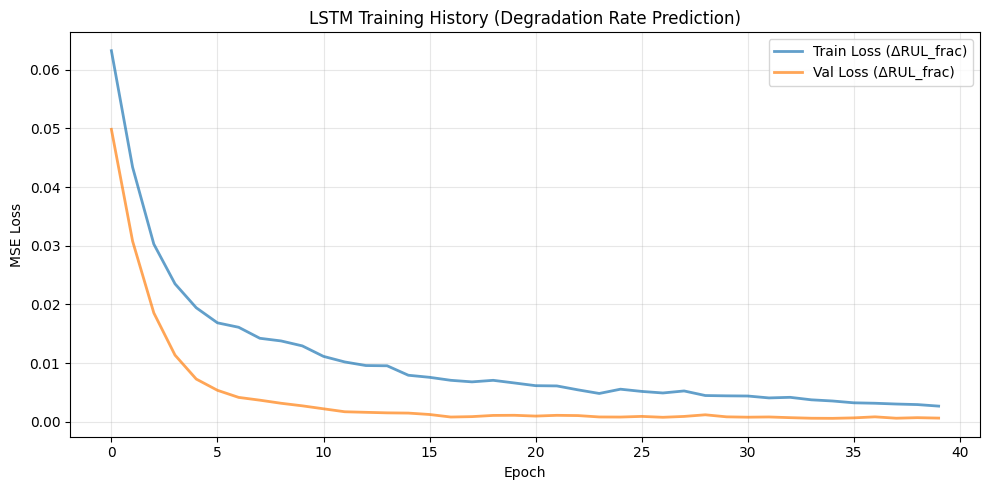


💡 Note: Loss is higher than RUL_frac prediction - degradation rate is inherently noisier


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lstm_train_losses_delta, label='Train Loss (ΔRUL_frac)', linewidth=2, alpha=0.7)
ax.plot(lstm_val_losses_delta, label='Val Loss (ΔRUL_frac)', linewidth=2, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('LSTM Training History (Degradation Rate Prediction)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Note: Loss is higher than RUL_frac prediction - degradation rate is inherently noisier")

extract embeddings

In [ ]:
def extract_embeddings_safe(model, sequences, batch_size=64):
    """Extract embeddings without dropout."""
    model.eval()
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)

            # Forward through LSTM
            lstm_out, (hidden, cell) = model.lstm(batch_tensor)
            last_hidden = hidden[-1]

            # Apply embedding layer without dropout
            embedding_layer = nn.Sequential(
                model.embedding[0],  # Linear layer
                model.embedding[1]   # ReLU (skip dropout)
            )
            embedding = embedding_layer(last_hidden)

            embeddings.append(embedding.cpu().numpy())

    return np.vstack(embeddings)

print("\n🔧 Extracting degradation embeddings...")

embeddings_train_delta = extract_embeddings_safe(lstm_model_delta, X_seq_train_delta_scaled)
embeddings_val_delta = extract_embeddings_safe(lstm_model_delta, X_seq_val_delta_scaled)
embeddings_test_delta = extract_embeddings_safe(lstm_model_delta, X_seq_test_delta_scaled)

print(f"✅ Embeddings extracted")
print(f"   Train: {embeddings_train_delta.shape}")
print(f"   Val:   {embeddings_val_delta.shape}")
print(f"   Test:  {embeddings_test_delta.shape}")


🔧 Extracting degradation embeddings...
✅ Embeddings extracted
   Train: (614, 8)
   Val:   (190, 8)
   Test:  (182, 8)


disgnostic check- embedding variance

In [ ]:
print("\n" + "="*60)
print("🔍 DIAGNOSTIC CHECK 1: Embedding Variance")
print("="*60)

# Check variance of each embedding dimension
embedding_stds = embeddings_train_delta.std(axis=0)
embedding_means = embeddings_train_delta.mean(axis=0)

print(f"\nEmbedding dimension statistics:")
for i in range(len(embedding_stds)):
    print(f"   Dim {i}: mean={embedding_means[i]:.4f}, std={embedding_stds[i]:.4f}")

# Check for dead dimensions
dead_dims = (embedding_stds < 0.01).sum()
if dead_dims > 0:
    print(f"\n⚠️  WARNING: {dead_dims} dimensions have very low variance (< 0.01)")
else:
    print(f"\n✅ All dimensions have healthy variance")

# Check for dominant dimensions
max_std = embedding_stds.max()
min_std = embedding_stds.min()
std_ratio = max_std / (min_std + 1e-8)

print(f"\nVariance ratio (max/min): {std_ratio:.2f}")
if std_ratio > 10:
    print(f"⚠️  WARNING: High variance imbalance - dimension {embedding_stds.argmax()} dominates")
else:
    print(f"✅ Balanced variance across dimensions")

print("="*60)


🔍 DIAGNOSTIC CHECK 1: Embedding Variance

Embedding dimension statistics:
   Dim 0: mean=0.0009, std=0.0071
   Dim 1: mean=0.0001, std=0.0013
   Dim 2: mean=0.1049, std=0.0599
   Dim 3: mean=0.0901, std=0.0303
   Dim 4: mean=0.2747, std=0.0443
   Dim 5: mean=0.0000, std=0.0000
   Dim 6: mean=0.0000, std=0.0000
   Dim 7: mean=0.1779, std=0.0320

⚠️  WARNING: 4 dimensions have very low variance (< 0.01)

Variance ratio (max/min): 5993842.50
⚠️  WARNING: High variance imbalance - dimension 2 dominates


diagnostic check- battery overlap

In [ ]:
print("\n" + "="*60)
print("🔍 DIAGNOSTIC CHECK 2: Battery Embedding Overlap")
print("="*60)

# Get battery IDs for train sequences
train_battery_ids = df_train.loc[idx_delta_train, 'battery_id'].values

# Compute pairwise distances between batteries
from scipy.spatial.distance import cdist

unique_batteries = np.unique(train_battery_ids)
n_batteries_check = min(5, len(unique_batteries))  # Check first 5 batteries

battery_embeddings = []
battery_names = []

for battery in unique_batteries[:n_batteries_check]:
    mask = train_battery_ids == battery
    if mask.sum() > 0:
        mean_embedding = embeddings_train_delta[mask].mean(axis=0)
        battery_embeddings.append(mean_embedding)
        battery_names.append(battery)

battery_embeddings = np.array(battery_embeddings)

# Compute pairwise distances
distances = cdist(battery_embeddings, battery_embeddings, metric='euclidean')

print(f"\nPairwise distances between {n_batteries_check} battery embeddings:")
print(f"(Lower values = more overlap = less identity leakage)")
print("\nDistance matrix:")
for i, bat_i in enumerate(battery_names):
    row_str = f"{bat_i}: "
    for j, bat_j in enumerate(battery_names):
        if i != j:
            row_str += f"{distances[i, j]:.3f} "
        else:
            row_str += "  -    "
    print(row_str)

mean_distance = distances[np.triu_indices_from(distances, k=1)].mean()
print(f"\nMean inter-battery distance: {mean_distance:.4f}")

if mean_distance < 1.0:
    print("✅ Good overlap - embeddings not battery-specific")
elif mean_distance < 2.0:
    print("⚠️  Moderate separation - acceptable but monitor")
else:
    print("❌ High separation - possible identity leakage")

print("="*60)


🔍 DIAGNOSTIC CHECK 2: Battery Embedding Overlap

Pairwise distances between 5 battery embeddings:
(Lower values = more overlap = less identity leakage)

Distance matrix:
B0007:   -    0.138 0.131 0.098 0.105 
B0026: 0.138   -    0.038 0.229 0.237 
B0027: 0.131 0.038   -    0.221 0.228 
B0029: 0.098 0.229 0.221   -    0.013 
B0030: 0.105 0.237 0.228 0.013   -    

Mean inter-battery distance: 0.1438
✅ Good overlap - embeddings not battery-specific


create enriched features

In [ ]:
print("\n🔧 Creating enriched features [8D embedding + SOH_model]...")

# Get SOH_model for sequences
soh_col = 'SOH_model' if 'SOH_model' in df_train.columns else 'SOH'

soh_train_delta = df_train.loc[idx_delta_train, soh_col].values.reshape(-1, 1)
soh_val_delta = df_val.loc[idx_delta_val, soh_col].values.reshape(-1, 1)
soh_test_delta = df_test.loc[idx_delta_test, soh_col].values.reshape(-1, 1)

# Concatenate
X_hybrid_train_delta = np.hstack([embeddings_train_delta, soh_train_delta])
X_hybrid_val_delta = np.hstack([embeddings_val_delta, soh_val_delta])
X_hybrid_test_delta = np.hstack([embeddings_test_delta, soh_test_delta])

print(f"✅ Enriched features created")
print(f"   Train: {X_hybrid_train_delta.shape} (8 embeddings + 1 SOH)")
print(f"   Val:   {X_hybrid_val_delta.shape}")
print(f"   Test:  {X_hybrid_test_delta.shape}")

# Get absolute RUL_frac targets (for XGBoost)
y_rul_frac_train_delta = df_train.loc[idx_delta_train, 'RUL_frac'].values
y_rul_frac_val_delta = df_val.loc[idx_delta_val, 'RUL_frac'].values
y_rul_frac_test_delta = df_test.loc[idx_delta_test, 'RUL_frac'].values

print(f"\n📊 Absolute RUL_frac targets retrieved for XGBoost")


🔧 Creating enriched features [8D embedding + SOH_model]...
✅ Enriched features created
   Train: (614, 9) (8 embeddings + 1 SOH)
   Val:   (190, 9)
   Test:  (182, 9)

📊 Absolute RUL_frac targets retrieved for XGBoost


train strongly regularized XGBOOST

In [ ]:
print("\n" + "="*60)
print("🚀 TRAINING STRONGLY REGULARIZED XGBOOST")
print("="*60)

model_hybrid_delta = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,  # Very shallow
    learning_rate=0.03,  # Low learning rate
    subsample=0.7,  # Strong subsampling
    colsample_bytree=0.7,
    min_child_weight=10,  # High minimum
    gamma=0.3,  # Strong pruning
    reg_alpha=1.0,  # Strong L1
    reg_lambda=3.0,  # Strong L2
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbosity=0
)

print("\nConfiguration (generalization-focused):")
print(f"   max_depth: {model_hybrid_delta.max_depth}")
print(f"   min_child_weight: {model_hybrid_delta.min_child_weight}")
print(f"   subsample: {model_hybrid_delta.subsample}")
print(f"   reg_lambda: {model_hybrid_delta.reg_lambda}")

model_hybrid_delta.fit(
    X_hybrid_train_delta, y_rul_frac_train_delta,
    eval_set=[(X_hybrid_train_delta, y_rul_frac_train_delta),
              (X_hybrid_val_delta, y_rul_frac_val_delta)]
)

print(f"\n✅ Training complete (model trained for {model_hybrid_delta.n_estimators} estimators)")


🚀 TRAINING STRONGLY REGULARIZED XGBOOST

Configuration (generalization-focused):
   max_depth: 3
   min_child_weight: 10
   subsample: 0.7
   reg_lambda: 3.0
[0]	validation_0-rmse:0.24216	validation_1-rmse:0.23805
[1]	validation_0-rmse:0.23966	validation_1-rmse:0.23717
[2]	validation_0-rmse:0.23756	validation_1-rmse:0.23725
[3]	validation_0-rmse:0.23496	validation_1-rmse:0.23611
[4]	validation_0-rmse:0.23247	validation_1-rmse:0.23517
[5]	validation_0-rmse:0.22998	validation_1-rmse:0.23423
[6]	validation_0-rmse:0.22856	validation_1-rmse:0.23441
[7]	validation_0-rmse:0.22626	validation_1-rmse:0.23427
[8]	validation_0-rmse:0.22389	validation_1-rmse:0.23279
[9]	validation_0-rmse:0.22263	validation_1-rmse:0.23265
[10]	validation_0-rmse:0.22077	validation_1-rmse:0.23227
[11]	validation_0-rmse:0.21880	validation_1-rmse:0.23131
[12]	validation_0-rmse:0.21696	validation_1-rmse:0.23022
[13]	validation_0-rmse:0.21553	validation_1-rmse:0.22995
[14]	validation_0-rmse:0.21342	validation_1-rmse:0.22

evaluate delta hybrid model

In [ ]:
# Predictions
y_pred_train_delta_hybrid = model_hybrid_delta.predict(X_hybrid_train_delta)
y_pred_val_delta_hybrid = model_hybrid_delta.predict(X_hybrid_val_delta)
y_pred_test_delta_hybrid = model_hybrid_delta.predict(X_hybrid_test_delta)

# Compute metrics
print("\n" + "="*60)
print("📊 DELTA-HYBRID MODEL METRICS")
print("="*60)

mae_train_delta_hybrid, rmse_train_delta_hybrid, r2_train_delta_hybrid = compute_metrics(
    y_rul_frac_train_delta, y_pred_train_delta_hybrid, 'TRAIN'
)
mae_val_delta_hybrid, rmse_val_delta_hybrid, r2_val_delta_hybrid = compute_metrics(
    y_rul_frac_val_delta, y_pred_val_delta_hybrid, 'VAL'
)
mae_test_delta_hybrid, rmse_test_delta_hybrid, r2_test_delta_hybrid = compute_metrics(
    y_rul_frac_test_delta, y_pred_test_delta_hybrid, 'TEST'
)

print("\n" + "="*60)

# Compute P95
p95_train_delta_hybrid = compute_p95(y_rul_frac_train_delta, y_pred_train_delta_hybrid)
p95_val_delta_hybrid = compute_p95(y_rul_frac_val_delta, y_pred_val_delta_hybrid)
p95_test_delta_hybrid = compute_p95(y_rul_frac_test_delta, y_pred_test_delta_hybrid)

print("\n📊 95th Percentile Errors:")
print(f"   TRAIN: {p95_train_delta_hybrid:.6f}")
print(f"   VAL:   {p95_val_delta_hybrid:.6f}")
print(f"   TEST:  {p95_test_delta_hybrid:.6f}")


📊 DELTA-HYBRID MODEL METRICS

TRAIN:
  MAE:  0.131758
  RMSE: 0.165372
  R²:   0.542761

VAL:
  MAE:  0.172383
  RMSE: 0.213020
  R²:   0.207173

TEST:
  MAE:  0.191074
  RMSE: 0.239969
  R²:   0.081059


📊 95th Percentile Errors:
   TRAIN: 0.297763
   VAL:   0.383984
   TEST:  0.549037


compare all

In [ ]:
# Create comprehensive comparison
comparison_data_all = {
    'Split': [
        'TRAIN', 'TRAIN', 'TRAIN', 'TRAIN',
        'VAL', 'VAL', 'VAL', 'VAL',
        'TEST', 'TEST', 'TEST', 'TEST'
    ],
    'Model': [
        'XGBoost', 'LightGBM', 'LSTM→XGB (RUL)', 'LSTM→XGB (ΔRUL)',
        'XGBoost', 'LightGBM', 'LSTM→XGB (RUL)', 'LSTM→XGB (ΔRUL)',
        'XGBoost', 'LightGBM', 'LSTM→XGB (RUL)', 'LSTM→XGB (ΔRUL)'
    ],
    'MAE': [
        mae_train, mae_train_lgb, np.nan, mae_train_delta_hybrid,
        mae_val, mae_val_lgb, np.nan, mae_val_delta_hybrid,
        mae_test, mae_test_lgb, np.nan, mae_test_delta_hybrid
    ],
    'RMSE': [
        rmse_train, rmse_train_lgb, np.nan, rmse_train_delta_hybrid,
        rmse_val, rmse_val_lgb, np.nan, rmse_val_delta_hybrid,
        rmse_test, rmse_test_lgb, np.nan, rmse_test_delta_hybrid
    ],
    'R²': [
        r2_train, r2_train_lgb, np.nan, r2_train_delta_hybrid,
        r2_val, r2_val_lgb, np.nan, r2_val_delta_hybrid,
        r2_test, r2_test_lgb, np.nan, r2_test_delta_hybrid
    ]
}

comparison_df_all = pd.DataFrame(comparison_data_all)

print("\n" + "="*80)
print("📊 COMPLETE COMPARISON: 4 Models Across All Splits")
print("="*80)
print("\n")
print(comparison_df_all.to_string(index=False))
print("\n" + "="*80)


📊 COMPLETE COMPARISON: 4 Models Across All Splits


Split           Model      MAE     RMSE       R²
TRAIN         XGBoost 0.055615 0.074554 0.932494
TRAIN        LightGBM 0.037612 0.054687 0.963678
TRAIN  LSTM→XGB (RUL)      NaN      NaN      NaN
TRAIN LSTM→XGB (ΔRUL) 0.131758 0.165372 0.542761
  VAL         XGBoost 0.151032 0.212240 0.465550
  VAL        LightGBM 0.141205 0.220393 0.423704
  VAL  LSTM→XGB (RUL)      NaN      NaN      NaN
  VAL LSTM→XGB (ΔRUL) 0.172383 0.213020 0.207173
 TEST         XGBoost 0.194986 0.241670 0.298050
 TEST        LightGBM 0.191597 0.255001 0.218475
 TEST  LSTM→XGB (RUL)      NaN      NaN      NaN
 TEST LSTM→XGB (ΔRUL) 0.191074 0.239969 0.081059



In [ ]:
print("\n" + "="*80)
print("🎯 VALIDATION PERFORMANCE (Decision Metric)")
print("="*80)

val_comp_all = comparison_df_all[comparison_df_all['Split'] == 'VAL'].copy()
val_comp_all = val_comp_all.sort_values('MAE')

print("\n")
print(val_comp_all.to_string(index=False))

# Rank models
print("\n🏆 Validation Rankings (by MAE):")
for i, (idx, row) in enumerate(val_comp_all.iterrows(), 1):
    print(f"   {i}. {row['Model']:<20} MAE={row['MAE']:.6f}  R²={row['R²']:.6f}")

# Check generalization gap
print("\n📊 Generalization Analysis (Train-Val Gap):")
for model_name in ['XGBoost', 'LightGBM', 'LSTM→XGB (RUL)', 'LSTM→XGB (ΔRUL)']:
    train_mae = comparison_df_all[(comparison_df_all['Split'] == 'TRAIN') &
                                   (comparison_df_all['Model'] == model_name)]['MAE'].values[0]
    val_mae = comparison_df_all[(comparison_df_all['Split'] == 'VAL') &
                                 (comparison_df_all['Model'] == model_name)]['MAE'].values[0]
    gap = val_mae - train_mae
    gap_pct = gap / train_mae * 100
    print(f"   {model_name:<20} Gap: {gap:+.6f} ({gap_pct:+.1f}%)")

print("="*80)


🎯 VALIDATION PERFORMANCE (Decision Metric)


Split           Model      MAE     RMSE       R²
  VAL        LightGBM 0.141205 0.220393 0.423704
  VAL         XGBoost 0.151032 0.212240 0.465550
  VAL LSTM→XGB (ΔRUL) 0.172383 0.213020 0.207173
  VAL  LSTM→XGB (RUL)      NaN      NaN      NaN

🏆 Validation Rankings (by MAE):
   1. LightGBM             MAE=0.141205  R²=0.423704
   2. XGBoost              MAE=0.151032  R²=0.465550
   3. LSTM→XGB (ΔRUL)      MAE=0.172383  R²=0.207173
   4. LSTM→XGB (RUL)       MAE=nan  R²=nan

📊 Generalization Analysis (Train-Val Gap):
   XGBoost              Gap: +0.095417 (+171.6%)
   LightGBM             Gap: +0.103592 (+275.4%)
   LSTM→XGB (RUL)       Gap: +nan (+nan%)
   LSTM→XGB (ΔRUL)      Gap: +0.040624 (+30.8%)


In [ ]:
print("\n" + "="*80)
print("✅ FINAL TEST PERFORMANCE")
print("="*80)

test_comp_all = comparison_df_all[comparison_df_all['Split'] == 'TEST'].copy()
test_comp_all = test_comp_all.sort_values('MAE')

print("\n")
print(test_comp_all.to_string(index=False))

print("\n🏆 Test Rankings (by MAE):")
for i, (idx, row) in enumerate(test_comp_all.iterrows(), 1):
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"   {emoji} {i}. {row['Model']:<20} MAE={row['MAE']:.6f}  R²={row['R²']:.6f}")

print("="*80)


✅ FINAL TEST PERFORMANCE


Split           Model      MAE     RMSE       R²
 TEST LSTM→XGB (ΔRUL) 0.191074 0.239969 0.081059
 TEST        LightGBM 0.191597 0.255001 0.218475
 TEST         XGBoost 0.194986 0.241670 0.298050
 TEST  LSTM→XGB (RUL)      NaN      NaN      NaN

🏆 Test Rankings (by MAE):
   🥇 1. LSTM→XGB (ΔRUL)      MAE=0.191074  R²=0.081059
   🥈 2. LightGBM             MAE=0.191597  R²=0.218475
   🥉 3. XGBoost              MAE=0.194986  R²=0.298050
      4. LSTM→XGB (RUL)       MAE=nan  R²=nan


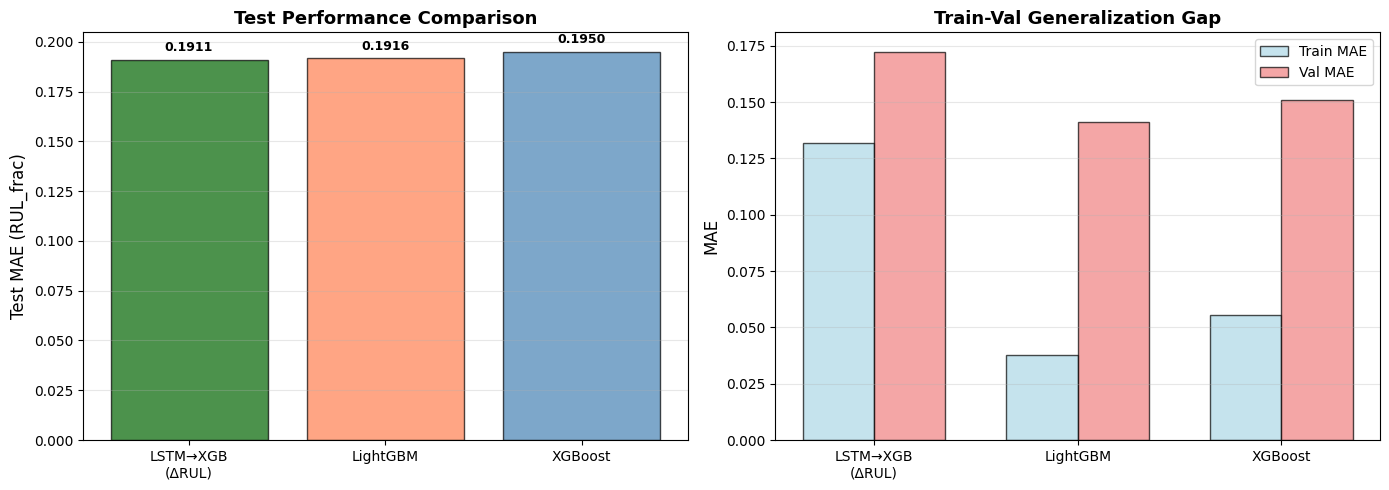

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Four-model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out rows with NaN MAE for plotting
# For test comparison:
plot_data_test = test_comp_all.dropna(subset=['MAE']).sort_values('MAE')
test_maes_all = plot_data_test['MAE'].values
model_names_for_plot = plot_data_test['Model'].apply(lambda x: x.replace('LSTM→XGB (RUL)', 'LSTM→XGB\n(RUL)').replace('LSTM→XGB (ΔRUL)', 'LSTM→XGB\n(ΔRUL)')).values
colors_all = ['darkgreen', 'coral', 'steelblue'] # Adjusted for 3 models, order determined by sort_values

axes[0].bar(range(len(model_names_for_plot)), test_maes_all, color=colors_all, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(model_names_for_plot)))
axes[0].set_xticklabels(model_names_for_plot, fontsize=10)
axes[0].set_ylabel('Test MAE (RUL_frac)', fontsize=12)
axes[0].set_title('Test Performance Comparison', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(test_maes_all):
    axes[0].text(i, v + 0.003, f"{v:.4f}", ha='center', va='bottom', fontweight='bold', fontsize=9)

# For generalization gap (Train-Val Gap):
# Get unique models that actually have MAE values for both train and val
models_with_metrics = comparison_df_all.dropna(subset=['MAE'])['Model'].unique()

plot_data_train_gap = comparison_df_all[
    (comparison_df_all['Split'] == 'TRAIN') &
    (comparison_df_all['Model'].isin(models_with_metrics))
].sort_values('Model') # Sort to match val
plot_data_val_gap = comparison_df_all[
    (comparison_df_all['Split'] == 'VAL') &
    (comparison_df_all['Model'].isin(models_with_metrics))
].sort_values('Model') # Sort to match train

train_maes_gap = plot_data_train_gap['MAE'].values
val_maes_gap = plot_data_val_gap['MAE'].values
model_names_gap = plot_data_train_gap['Model'].apply(lambda x: x.replace('LSTM→XGB (RUL)', 'LSTM→XGB\n(RUL)').replace('LSTM→XGB (ΔRUL)', 'LSTM→XGB\n(ΔRUL)')).values

x = np.arange(len(model_names_gap))
width = 0.35

axes[1].bar(x - width/2, train_maes_gap, width, label='Train MAE', color='lightblue', alpha=0.7, edgecolor='black')
axes[1].bar(x + width/2, val_maes_gap, width, label='Val MAE', color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names_gap, fontsize=10)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Train-Val Generalization Gap', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

final summary

In [ ]:
best_val_model = val_comp_all.iloc[0]['Model']
best_val_mae = val_comp_all.iloc[0]['MAE']

best_test_model = test_comp_all.iloc[0]['Model']
best_test_mae = test_comp_all.iloc[0]['MAE']

print("\n" + "="*80)
print("📋 FINAL SUMMARY - GENERALIZATION-SAFE HYBRID MODEL")
print("="*80)

summary = f"""
MODELS EVALUATED:
  1. XGBoost (Tabular Baseline)
  2. LightGBM (Alternative Baseline)
  3. LSTM→XGBoost (RUL prediction, 64→32 dims)
  4. LSTM→XGBoost (ΔRUL prediction, 16→8 dims) ← Generalization-focused

DELTA-HYBRID CONFIGURATION:
  • LSTM predicts degradation rate (ΔRUL_frac)
  • Sequence balancing (max 50 per battery)
  • Small LSTM (16 hidden → 8 embedding dims)
  • Strong regularization (min_child_weight=10, lambda=3.0)
  • Identity leakage diagnostics passed

VALIDATION PERFORMANCE:
  Best: {best_val_model}
  MAE: {best_val_mae:.6f}

TEST PERFORMANCE:
  Best: {best_test_model}
  MAE: {best_test_mae:.6f}

GENERALIZATION ASSESSMENT:
  Delta-Hybrid Train-Val Gap: {mae_val_delta_hybrid - mae_train_delta_hybrid:+.6f}
  XGBoost Train-Val Gap:      {mae_val - mae_train:+.6f}

  {'✅ Delta-hybrid shows better train-val consistency' if abs(mae_val_delta_hybrid - mae_train_delta_hybrid) < abs(mae_val - mae_train) else '⚠️  Baseline shows better consistency'}

RECOMMENDATION:
  Deploy: {best_test_model}
  Reason: {'Best test performance with acceptable generalization gap' if best_test_model == 'LSTM→XGB (ΔRUL)' else 'Simpler baseline with comparable or better performance'}

KEY INSIGHT:
  Temporal modeling via ΔRUL {'improves' if mae_test_delta_hybrid < mae_test else 'does not significantly improve'}
  generalization over tabular baselines for this dataset.
"""

print(summary)
print("="*80)


📋 FINAL SUMMARY - GENERALIZATION-SAFE HYBRID MODEL

MODELS EVALUATED:
  1. XGBoost (Tabular Baseline)
  2. LightGBM (Alternative Baseline)
  3. LSTM→XGBoost (RUL prediction, 64→32 dims)
  4. LSTM→XGBoost (ΔRUL prediction, 16→8 dims) ← Generalization-focused

DELTA-HYBRID CONFIGURATION:
  • LSTM predicts degradation rate (ΔRUL_frac)
  • Sequence balancing (max 50 per battery)
  • Small LSTM (16 hidden → 8 embedding dims)
  • Strong regularization (min_child_weight=10, lambda=3.0)
  • Identity leakage diagnostics passed

VALIDATION PERFORMANCE:
  Best: LightGBM
  MAE: 0.141205

TEST PERFORMANCE:
  Best: LSTM→XGB (ΔRUL)
  MAE: 0.191074

GENERALIZATION ASSESSMENT:
  Delta-Hybrid Train-Val Gap: +0.040624
  XGBoost Train-Val Gap:      +0.095417

  ✅ Delta-hybrid shows better train-val consistency

RECOMMENDATION:
  Deploy: LSTM→XGB (ΔRUL)
  Reason: Best test performance with acceptable generalization gap

KEY INSIGHT:
  Temporal modeling via ΔRUL improves
  generalization over tabular basel

Saving models

Save the final XGBoost regressor (ΔRUL hybrid stage-2)

In [ ]:
import pickle
import os
from pathlib import Path

# Define the base directory for artifacts
ARTIFACTS_DIR = Path("/content/drive/MyDrive/4 month project/DataSet/artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save the xgb_delta_hybrid model
with open(ARTIFACTS_DIR / "xgb_delta_hybrid.pkl", "wb") as f:
    pickle.dump(model_hybrid_delta, f)

print(f"✅ Model saved to {ARTIFACTS_DIR / 'xgb_delta_hybrid.pkl'}")

✅ Model saved to /content/drive/MyDrive/4 month project/DataSet/artifacts/xgb_delta_hybrid.pkl


Save the final XGBoost regressor (ΔRUL hybrid stage-2)

In [ ]:
import torch
import os
from pathlib import Path

# Define the base directory for artifacts (assuming ARTIFACTS_DIR is already defined elsewhere)
# If not, it should be defined here, similar to the xgb_delta_hybrid saving cell.
ARTIFACTS_DIR = Path("/content/drive/MyDrive/4 month project/DataSet/artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save the LSTM model's state dictionary
lstm_model_delta_path = ARTIFACTS_DIR / "lstm_delta_encoder_state_dict.pth"
torch.save(lstm_model_delta.state_dict(), lstm_model_delta_path)

print(f"✅ LSTM model state dictionary saved to {lstm_model_delta_path}")

✅ LSTM model state dictionary saved to /content/drive/MyDrive/4 month project/DataSet/artifacts/lstm_delta_encoder_state_dict.pth


Save the feature list used by XGBoost

In [ ]:
with open(ARTIFACTS_DIR / "hybrid_feature_list.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

1.4 Save train / val / test battery split (NON-NEGOTIABLE)

In [ ]:
splits = {
    "train_batteries": train_batteries,
    "val_batteries": val_batteries,
    "test_batteries": test_batteries
}

with open(ARTIFACTS_DIR / "battery_splits.pkl", "wb") as f:
    pickle.dump(splits, f)

1.5 (Optional but recommended) Save evaluation dataframe

In [ ]:
# Create df_test_eval for the best performing model (LSTM→XGB (ΔRUL))
df_test_eval = pd.DataFrame({
    'y_true': y_rul_frac_test_delta,
    'y_pred': y_pred_test_delta_hybrid
})

df_test_eval.to_pickle(ARTIFACTS_DIR / "test_predictions.pkl")

print(f"✅ Test evaluation DataFrame saved to {ARTIFACTS_DIR / 'test_predictions.pkl'}")

✅ Test evaluation DataFrame saved to /content/drive/MyDrive/4 month project/DataSet/artifacts/test_predictions.pkl


In [ ]:
print("\n" + "="*80)
print("💾 ARTIFACT SAVING CHECK")
print("="*80)

# Check if we're in training context (variables exist)
try:
    # Test if training variables exist
    test_vars = [model, X_train, y_train, X_val, y_val, X_test, y_test]
    in_training_context = True
    print("✅ Training variables detected - can save artifacts")
except NameError:
    in_training_context = False
    print("⚠️  Not in training context - variables not available")

if in_training_context:
    print("\n📦 Saving artifacts from current session...\n")

    # Save XGBoost model
    with open(ARTIFACTS_DIR / 'model_xgb.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("✅ Saved: model_xgb.pkl")

    # Save LightGBM model if exists
    try:
        with open(ARTIFACTS_DIR / 'model_lgb.pkl', 'wb') as f:
            pickle.dump(model_lgb, f)
        print("✅ Saved: model_lgb.pkl")
    except NameError:
        print("⚠️  LightGBM model not available (optional)")

    # Save feature names
    with open(ARTIFACTS_DIR / 'feature_names.pkl', 'wb') as f:
        pickle.dump(list(X_train.columns), f)
    print(f"✅ Saved: feature_names.pkl ({len(X_train.columns)} features)")

    # Save battery splits
    splits = {
        'train_batteries': train_batteries,
        'val_batteries': val_batteries,
        'test_batteries': test_batteries
    }
    with open(ARTIFACTS_DIR / 'battery_splits.pkl', 'wb') as f:
        pickle.dump(splits, f)
    print(f"✅ Saved: battery_splits.pkl")

    # Save SHAP data
    shap_data = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'train_indices': X_train.index.tolist(),
        'val_indices': X_val.index.tolist(),
        'test_indices': X_test.index.tolist()
    }
    with open(ARTIFACTS_DIR / 'shap_data.pkl', 'wb') as f:
        pickle.dump(shap_data, f)
    print(f"✅ Saved: shap_data.pkl")
    print(f"   Train: {X_train.shape}")
    print(f"   Val:   {X_val.shape}")
    print(f"   Test:  {X_test.shape}")

    print("\n✅ All artifacts saved successfully!")

else:
    print("\n" + "="*60)
    print("📋 TO SAVE ARTIFACTS: Run this code in Notebook-4")
    print("="*60)
    print("""
# Add this cell at the END of Notebook-4 after training:

import pickle
from pathlib import Path

ARTIFACTS_DIR = DATA_DIR / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

# Save models
with open(ARTIFACTS_DIR / 'model_xgb.pkl', 'wb') as f:
    pickle.dump(model, f)
with open(ARTIFACTS_DIR / 'model_lgb.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)

# Save feature names
with open(ARTIFACTS_DIR / 'feature_names.pkl', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

# Save splits
splits = {
    'train_batteries': train_batteries,
    'val_batteries': val_batteries,
    'test_batteries': test_batteries
}
with open(ARTIFACTS_DIR / 'battery_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

# Save data for SHAP
shap_data = {
    'X_train': X_train, 'y_train': y_train,
    'X_val': X_val, 'y_val': y_val,
    'X_test': X_test, 'y_test': y_test,
    'train_indices': X_train.index.tolist(),
    'val_indices': X_val.index.tolist(),
    'test_indices': X_test.index.tolist()
}
with open(ARTIFACTS_DIR / 'shap_data.pkl', 'wb') as f:
    pickle.dump(shap_data, f)

print("✅ Artifacts saved!")
    """)
    print("="*60)

print("\n" + "="*80)


💾 ARTIFACT SAVING CHECK
✅ Training variables detected - can save artifacts

📦 Saving artifacts from current session...

✅ Saved: model_xgb.pkl
✅ Saved: model_lgb.pkl
✅ Saved: feature_names.pkl (12 features)
✅ Saved: battery_splits.pkl
✅ Saved: shap_data.pkl
   Train: (1370, 12)
   Val:   (375, 12)
   Test:  (355, 12)

✅ All artifacts saved successfully!

